## Foundations of Data Science: Inferential Thinking by Resampling

Mirroring course Jupyter notebook except using standard modules instead of Berkeley data science module.

## Lecture 9: Causality

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 9)


/home/paul/Software/anaconda2/envs/ds36_env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
bta_data = pd.read_csv('data/bta.csv')
bta_data

,Group,Result
0,Control,1.000
1,Control,1.000
2,Control,0.000
3,Control,0.000
...,...,...
27,Treatment,0.000
28,Treatment,0.000
29,Treatment,0.000
30,Treatment,0.000


In [3]:
bta_data.groupby('Group').describe().T

Group         Control  Treatment
Result count   16.000     15.000
       mean     0.125      0.600
       std      0.342      0.507
       min      0.000      0.000
       25%      0.000      0.000
       50%      0.000      1.000
       75%      0.000      1.000
       max      1.000      1.000

In [4]:
bta_data.groupby('Group')['Result'].value_counts()

Group      Result
Control    0.000     14
           1.000      2
Treatment  1.000      9
           0.000      6
Name: Result, dtype: int64

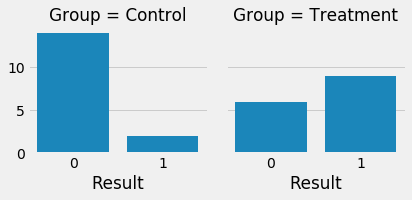

In [5]:
# FacetGrid - wrap columns
g = sns.FacetGrid(bta_data, col="Group")
g.map(sns.countplot, 'Result', order=([0, 1]))
plt.show()

#### With proportion z-test

In [6]:
# Z-test approximating binomial with normal distribution
#  null: the population proportions are equal
# 
# Note: Violates rule that the number of success and number of failures 
#       must be >5 for each sample.
#
# Using x + 2 and n + 4 to mitigate small sample size

x_a = bta_data.loc[bta_data['Group'] == 'Control']['Result'].sum() + 2
n_a = len(bta_data.loc[bta_data['Group'] == 'Control']) + 4
x_b = bta_data.loc[bta_data['Group'] == 'Treatment']['Result'].sum() + 2
n_b = len(bta_data.loc[bta_data['Group'] == 'Treatment']) + 4 

p_a = (x_a / n_a)
p_b = (x_b / n_b)
p_c = (x_a + x_b) / (n_a + n_b)  # pooled proportion
sigma = np.sqrt(p_c * (1 - p_c) * (1 / n_a + 1 / n_b))
z_score = np.abs(p_a - p_b) / sigma
p_val = (stats.norm.sf(z_score) * 2)
print('The p-value for the proportion = {0:.4f}'.format(p_val))

# The statsmodels module has a function for this
z_score, p_val = sm.stats.proportions_ztest([x_a, x_b], [n_a, n_b])
print('The p-value for the proportion = {0:.4f} (using statsmodels module)'.format(p_val))

The p-value for the proportion = 0.0150
The p-value for the proportion = 0.0150 (using statsmodels module)


#### With simulation

Small proportion of pain relief in control group still a problem?

In [22]:
n_ctrl = len(bta_data.loc[bta_data['Group'] == 'Control'])
n_treat = len(bta_data.loc[bta_data['Group'] == 'Treatment'])
sim_diffs = []
sim_values = bta_data['Result'].values.copy()

for _ in range(10000):
    np.random.shuffle(sim_values)
    sim_diffs.append(np.abs(sim_values[:n_ctrl].sum() / n_ctrl -
                            sim_values[n_ctrl:].sum() / n_treat))

In [23]:
group_proportions = (bta_data.groupby('Group')['Result']
                     .apply(lambda srs: srs.sum() / len(srs)))

obs_diff = np.abs(group_proportions[1] - group_proportions[0])

display(group_proportions)
print(obs_diff)

Group
Control     0.125
Treatment   0.600
Name: Result, dtype: float64

0.475


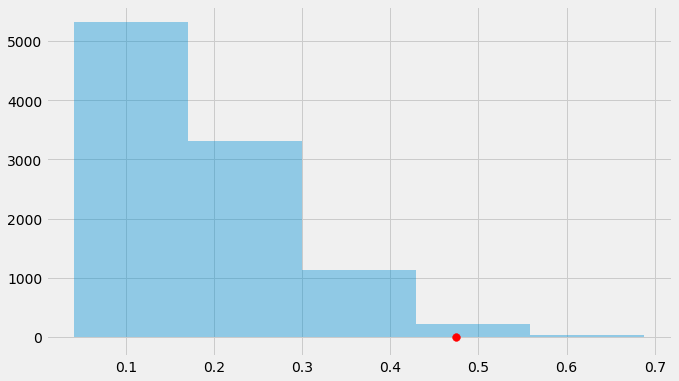

In [25]:
sns.distplot(sim_diffs, kde=False, bins=5)
plt.scatter(obs_diff, 0, color='red', s=60, zorder=2);
plt.show()

In [28]:
sim_p_value = (len([diff for diff in sim_diffs if diff >= obs_diff]) / 
               len(sim_diffs))

sim_p_value

0.0092